# PySIAF Observation Footprint Viewer
***

## Learning Goals
- Know the requirements for generating a telescope footprint
- Create a plot of a footprint in the telescope's reference frame
- Create a plot of a footrpint on the sky

## Introduction
This Notebook is a replacement for a web-based footprint viewer, and is designed as a "quick look" tool. Scientists intending to propose for Observations should use the [Astronomer's Proposal Tool (APT)](https://www.stsci.edu/scientific-community/software/astronomers-proposal-tool-apt).

Note that since PySIAF covers only HST, JWST, and Roman, footprint for other telescopes cannot be generated using this Notebook.

## Imports
- `selectSIAF` is a script that hides some of the complexities of this Notebook. Curious readers may wish to explore this file.
- `numpy` is not listed in the import cell, but is necessary to run the `selectSIAF` script
- `ipyaladin` plots the footprints on to a survey background

In [1]:
from astroquery.mast import Mast
from ipyaladin import Aladin
from selectSIAF import defineApertures, getVertices, computeStcsFootprint

import matplotlib.pyplot as plt
import pysiaf

## Select a Telescope, Instrument, and Aperture
In order to display a fooprint, we must first select three criteria:
1. Telescope. This must be a telescope with data in [pysiaf](https://pysiaf.readthedocs.io/en/stable/index.html); at present, this is HST, JWST, and Roman.
2. Instrument. The instrument used for the observation. The valid acronyms are listed in code comments in the cell below.
3. Aperture. For a full list of valid apertures, see the instrument documentation:
    - [HST User Documentation Homepage](https://hst-docs.stsci.edu)
    - [JWST MIRI Homepage](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument) (JWST has no instrument homepage; use the site navigation too reach other instrument pages)
    - [Roman Instruments Homepage](https://roman-docs.stsci.edu/roman-instruments-home)

### Example: Roman WFI
In the code cell below, we'll set some variables to hold these three selections. In this example, we're going to plot all 18 apertures from the Roman Space Telescope's Wide Field Instrument.

For completeness, examples for HST and JWST are available but commented out.

In [2]:
# define telescope, instrument, and aperture

selectedTelescope = 'roman'
selectedInstrument = 'WFI'      #Allowed options ALL, WFI, CGI
selectedAperture = 'ALL'        #Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'hst'
# selectedInstrument = 'ALL'     #Allowed options ALL, ACS, COS, FGS, NICMOS, STIS, WFC3
# selectedAperture = 'ALL'       #Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'jwst'
# selectedInstrument = 'ALL'     #Allowed options ALL, FGS, MIRI, NIRCAM, NIRSPEC, NIRISS
# selectedAperture = 'ALL'       #Allowed options ALL or individual apertures listed in instrument documentation

## Configure Apertures, Telescope Coordinate System

To simplify this Notebook, the `defineApertures` function from `selectSIAF` is essentially a lookup table, translating user-friendly instrument names into the correct corresponding apertures. 

This same function also generates the correct `V2Ref` and `V3Ref` offset angles. These V2/V3 values answer the question "what angle lies between this instrument and the line-of-sight of the telescope?". This is quite useful since, barring a catastrophic event, the instruments do not change their alignment relative to the line-of-sight.


In [3]:
# Set up aperture list and reference coordinates
apertureList, V2Ref, V3Ref = defineApertures(selectedTelescope, selectedInstrument, selectedAperture)

### Optional: Plot Footprint in Telescope Frame

Although not necessary to generate the final image, it is possible to plot the telescope apertures. We'll be plotting in a coordinate system that uses the telescope's pointing direction as (0,0); because of this, we don't need information about the celestial target or roll angle.

*Note: labels are useful for Roman WFI, but may be cluttered for other missions. You can toggle them off by setting `label=False` below.*

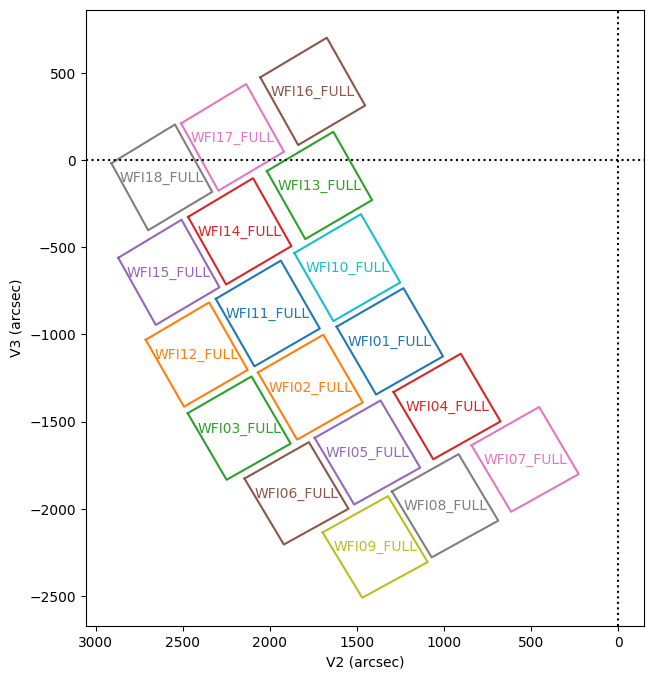

In [4]:
# OPTIONAL : set up plot of apertures (only works for QUAD, RECT, PICK aperture shapes)

# Set up the figure
plt.figure(figsize=(8, 8), facecolor='w', edgecolor='k')
plt.gca().invert_xaxis()

# iterate through apertures, then plot
for aperture in apertureList:
    # circles are not properly plotted, skip
    if aperture.AperShape!='CIRC':
        # set labels=False to remove them
        aperture.plot(label=True)

# Add guide lines for boresight (V2, V3) = (0, 0)
plt.axvline(color='k', linestyle=":")
plt.axhline(color='k', linestyle=":")

# Display the plot
plt.show() 

## Specifying a Target

For convenience, we can use the `resolve_object` function from the MAST module of `astroquery` to get our coordinates. This isn't necessary if you already know the exact coordinates; however, you should note formatting below that is necessary for `PySIAF` and `Aladin` to understand your query.

In [5]:
# Resolve the target name to coordinates
coords = Mast.resolve_object("M101")
coords

<SkyCoord (ICRS): (ra, dec) in deg
    (210.802429, 54.34875)>

Using MAST to resolve our target returns a [skycoord](https://docs.astropy.org/en/stable/coordinates/) object. We need two different formats to satisfy `pysiaf` and `Aladin`. `pysiaf` requires separate ra/dec objects, while `Aladin` is looking for a string containing both.

Fortunately, `skycoord` objects are flexible enough to handle both of these requirements with straightforward calls:

In [6]:
# get the values for SIAF
targetRa = coords.ra
targetDec = coords.dec

coords_str = coords.to_string()

# print out these values to check their conversions
print(f"RA:     {targetRa}\nDEC:    {targetDec}\nString: {coords_str}")

RA:     210.802429 deg
DEC:    54.34875 deg
String: 210.802 54.3488


There's a little bit of rounding as a result of our `to_string()` call. As we'll see later on, we only need this string to point the Aladin viewer at the right section of the sky; a little bit of rounding won't affect our view much.

## Telescope Position Angle

The last variable we need to set before using `pysiaf` is the telescope position angle. From the docstring of the `attitude_matrix` function:
>Position angle of V3 axis at nu2,nu3 measured from North to East (default unit is degree)

In plain English, this is the telescope roll angle; with the telescope fixed on the target, it rotates around its V1 (line-of-sight) axis. Modifying this value will cause the footprints to "roll" around the target.

In [7]:
# can be any value between 0 and 360
telescopePositionAngle = 0

## Generate The Attitude Matrix

At this point, we've generated footprints in the telescope's field of view. Now, we need to translate this into a view on the sky, in RA/Dec coordinates. This is handled by the `attitude_matrix` function, which is doing some matrix multiplication behind the scenes.

In [8]:
# Set telescope pointing matrix: "attitude matrix"
attmat = pysiaf.utils.rotations.attitude_matrix(V2Ref, V3Ref, targetRa, targetDec, telescopePositionAngle)

## Calculate Sky Regions

The final step is to convert to the [IVOA Space-Time Coordinate Metadata Linear String Implementation (STS-C)](https://ivoa.net/documents/STC-S/). Do not fear this verbose name; it's a method of standardizing footprints in string formats. The specifics depend on the particular shape used. For the curious, the `computeStcsFootprint` function from `selectSIAF` is what calcuates these strings in this Notebook.

Since `Aladin` knows how to parse this format, it will be able to plot it on a sky background of our choice. It is not particularly human readable, but we'll print it out anyway.

In [9]:
# Loop through aperture list  (only works for QUAD, RECT, CIRC aperture shapes)
# Transform to sky coordinates, build footprints for passing to Aladin
combinedSregion=''
for apertureSiaf in apertureList:
    apertureSiaf.set_attitude_matrix(attmat)
    xVertices, yVertices = getVertices(apertureSiaf)
    
    # Skip PICK which do not have vertices
    if (xVertices is not None and yVertices is not None):
        skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
        apertureSregion = computeStcsFootprint(apertureSiaf, skyRa, skyDec)
        combinedSregion+=apertureSregion
        
print('\n'+combinedSregion)


POLYGON ICRS 210.83611985 54.33128130 210.65317562 54.39264077 210.54552436 54.28382095 210.72855928 54.22325349 POLYGON ICRS 211.05072223 54.25819775 210.87237008 54.31853478 210.76486297 54.21068717 210.94350685 54.15129373 POLYGON ICRS 211.24158252 54.19262585 211.06815350 54.25175159 210.96096136 54.14495304 211.13485997 54.08690550 POLYGON ICRS 210.68074382 54.22718974 210.49702273 54.28787302 210.38969434 54.17966469 210.57318542 54.11982216 POLYGON ICRS 210.89577811 54.15413874 210.71626733 54.21367993 210.60869595 54.10650848 210.78819725 54.04796207 POLYGON ICRS 211.08624525 54.08900017 210.91132941 54.14723080 210.80375288 54.04116784 210.97886100 53.98405158 POLYGON ICRS 210.46906894 54.14198627 210.28418989 54.20221869 210.17805932 54.09489689 210.36234379 54.03549847 POLYGON ICRS 210.68550000 54.06878215 210.50418382 54.12784112 210.39736159 54.02156548 210.57830544 53.96349864 POLYGON ICRS 210.87378208 54.00349455 210.69645028 54.06121944 210.58925428 53.95605712 210.766

## Initialize Aladin
Let's start the Aladin viewer. We're loading a default field of view of 1 degree, with DSS as the background survey. Depending on your screen size, you may need to adjust the `height` (in pixels) to get the best view.

**NOTE:** The footprint will not show up right up away!

In [10]:
aladin = Aladin(height=600,fov=1, survey="P/DSS2/color", target=coords_str)
aladin

Aladin(fov=1.0, height=600, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color',…

This looks great, but where's our footprint? Well, we can only add an overlay once `Aladin` is already up and running. Let's add it now:

In [11]:
# Add the footprint with a hexcode for the color; you can also enter, e.g. "green"
aladin.add_overlay_from_stcs(combinedSregion, color="#70CBFF")

Done! Our footprint should be visible now. (If it is not visible, try running the `add_overlay` command again, then adjusting the zoom level. It sometimes takes a minute for Aladin to be responsive to the overlay command)

## About this Notebook

If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu.

**Authors:** Brian McLean, Thomas Dutkiewicz <br>
**Keywords:** Footprints <br>
**Last Updated:** May 2024 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 